# Builiding a local RAG Agent for VisionOS Coding

## Load in modules and setup Langsmith

In [4]:
import os
from dotenv import load_dotenv, find_dotenv

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langsmith import Client

In [5]:
load_dotenv(find_dotenv())
os.environ["LANGCHAIN_API_KEY"] = str(os.getenv("LANGCHAIN_API_KEY"))
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "custom-rag-project"

## Load Model: Mistral 7B

In [6]:
# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters

# Load the LangSmith Client and Test Run
client = Client()

model = "mistral:instruct"
llm = ChatOllama(model=model)
prompt = ChatPromptTemplate.from_template("Write code to {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# https://python.langchain.com/docs/expression_language/why
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for production
print(chain.invoke({"topic": "create a wrapper function that tests for errors and logs them"}))

 Here is an example of how you can create a wrapper function in JavaScript that tests for errors and logs them using the `try-catch` block:

```javascript
function wrapFunction(func, message) {
  return function() {
    try {
      return func.apply(this, arguments);
    } catch (error) {
      console.log(`[${new Date().toLocaleString()}] Error: ${message} - ${error.message}`);
      throw error;
    }
  };
}
``

// Usage example
function add(x, y) {
  return x + y;
}

const wrappedAdd = wrapFunction(add, 'Error message: add function');
const result = wrappedAdd(5, 10); // No error, the function works as intended

try {
  const wrongFunction = () => {};
  const result = wrongFunction();
} catch (error) {
  // This block will not be executed since there is no error in the previous code.
  console.log('An error occurred:', error.message);
}

const wrappedWrongFunction = wrapFunction(wrongFunction, 'Error message: wrongFunction');
try {
  wrappedWrongFunction();
} catch (error) {
  conso

In [7]:
import json
#open json file
with open('/Users/seangorman/code-projects/rag-project/scraped_docs_updated_again.json') as f:
  data = json.load(f)

data

#for each dict in douments, add each element in code examples to the end of content, have each element in code examples be a new paragraph
for i in range(len(data['documents'])):
    for j in range(len(data['documents'][i]['code_examples'])):
        data['documents'][i]['content'] += '\n\n\n\n' + data['documents'][i]['code_examples'][j]

#open json file
with open('data_docs.json', 'w') as f:
    json.dump(data, f)

In [29]:
with open('data_docs.json') as f:
  data = json.load(f)

## Prep Docs

These documents were scraped using selenium and beautiful soup. Here, I'm counting up the total number of tokens in our document to see what we're working with. Mistral 7b can handle up to 32K tokens in it's context window, so we'll need to account for this. 

In [12]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
import json
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


#load in scraped_docs_updates.json
with open("scraped_docs_updated_again.json", "r") as file:
    docs = json.load(file)

In [13]:
docs['documents'][5]

{'url': 'https://developer.apple.com/documentation/visionos/world',
 'title': 'Hello World | Apple Developer Documentation',
 'content': 'App construction Creating your first visionOS app Adding 3D content to your app Creating fully immersive experiences in your app Drawing sharp layer-based content in visionOS Design Designing for visionOS Adopting best practices for privacy and user preferences Improving accessibility support in your visionOS app SwiftUI Hello World Presenting windows and spaces Positioning and sizing windows RealityKit and Reality Composer Pro Swift Splash Diorama Understanding RealityKit’s modular architecture Designing RealityKit content with Reality Composer Pro Capturing screenshots and video from Apple Vision Pro for 2D viewing ARKit Happy Beam Setting up access to ARKit data Incorporating real-world surroundings in an immersive experience Placing content on detected planes Tracking specific points in world space   You can use visionOS scene types and styles to

In [14]:
docs_texts = [d['content'] for d in docs['documents']]
docs_code = [d['code_examples'] for d in docs['documents']]
combined_docs = [d['content'] + " " + " ".join(d['code_examples']) for d in docs['documents']]
# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in combined_docs]

<function matplotlib.pyplot.show(close=None, block=None)>

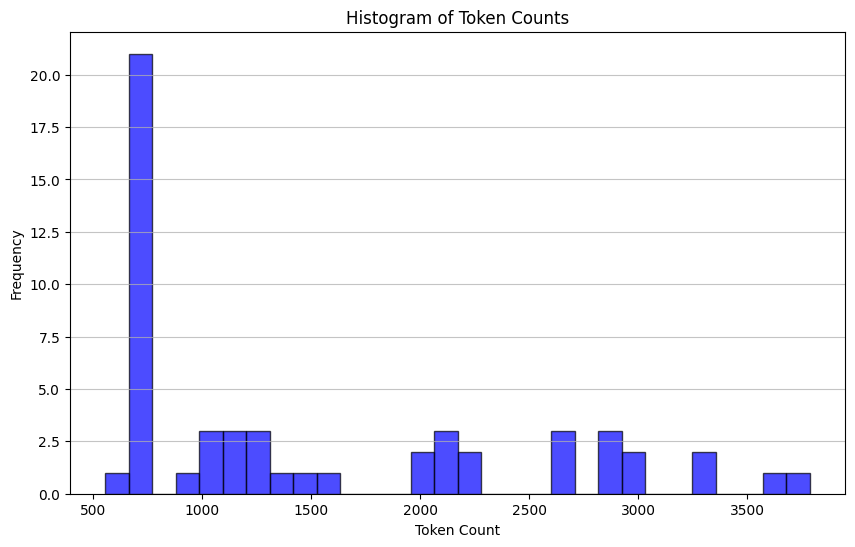

In [15]:
# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [16]:
print(f"Total number of counts: {sum(counts)}")

Total number of counts: 81966


In [17]:
from langchain_community.document_loaders import JSONLoader

loader = JSONLoader(
    file_path='scraped_docs_updated_again.json', #data_docs
    jq_schema=".documents[]",
    content_key="content",
    #is_content_key_jq_parsable=True,
    )

data = loader.load()
data


urls = JSONLoader(
    file_path='scraped_docs_updated_again.json',
    jq_schema=".documents[]",
    content_key="url",
    )

titles = JSONLoader(
    file_path='scraped_docs_updated_again.json',
    jq_schema=".documents[]",
    content_key="title",
    )

titles = titles.load()
urls = urls.load()

In [18]:
#update the metadata function to include the title and url
def update_metadata(record, titles, urls):

    sources = [urls[i].page_content for i in range(len(urls))],
    titles = [titles[i].page_content for i in range(len(titles))]

    
    for i in range(len(record)):
        seq_count = 1
        record[i].metadata = {"source": sources[0][i], "title": titles[i], 'seq_num': seq_count}
        seq_count += 1
    return record

update_metadata(data, titles, urls)

data[0].metadata

{'source': 'https://developer.apple.com/documentation/visionos',
 'title': 'visionOS | Apple Developer Documentation',
 'seq_num': 1}

In [28]:
data[0]

Document(page_content='Global Nav Open MenuGlobal Nav Close Menu Apple Developer Apple Developer News Discover Design Develop Distribute Support Account  Downloads Documentation Videos Forums Xcode App construction Creating your first visionOS app Adding 3D content to your app Creating fully immersive experiences in your app Drawing sharp layer-based content in visionOS Design Designing for visionOS Adopting best practices for privacy and user preferences Improving accessibility support in your visionOS app SwiftUI Hello World Presenting windows and spaces Positioning and sizing windows RealityKit and Reality Composer Pro Swift Splash Diorama Understanding RealityKit’s modular architecture Designing RealityKit content with Reality Composer Pro Capturing screenshots and video from Apple Vision Pro for 2D viewing ARKit Happy Beam Setting up access to ARKit data Incorporating real-world surroundings in an immersive experience Placing content on detected planes Tracking specific points in 

## Local Vecstore

In [20]:
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True)

<All keys matched successfully>


In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_mistralai import MistralAIEmbeddings
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.embeddings import LlamaCppEmbeddings


# Embed and index Nomic v1.5
embd_model_path = "nomic-embed-text-v1.5.Q2_K.gguf"
embedding = LlamaCppEmbeddings(model_path=embd_model_path, n_batch=512, verbose=False)


llama_model_loader: loaded meta data with 23 key-value pairs and 112 tensors from nomic-embed-text-v1.5.Q2_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = nomic-bert
llama_model_loader: - kv   1:                               general.name str              = nomic-embed-text-v1.5
llama_model_loader: - kv   2:                     nomic-bert.block_count u32              = 12
llama_model_loader: - kv   3:                  nomic-bert.context_length u32              = 2048
llama_model_loader: - kv   4:                nomic-bert.embedding_length u32              = 768
llama_model_loader: - kv   5:             nomic-bert.feed_forward_length u32              = 3072
llama_model_loader: - kv   6:            nomic-bert.attention.head_count u32              = 12
llama_model_loader: - kv   7:    nomic-bert.attention.layer_norm

In [24]:
# Index
vectorstore = Chroma.from_documents(
    documents=data,
    collection_name="rag-chroma",
    embedding=embedding,
)

retriever = vectorstore.as_retriever()


llama_print_timings:        load time =    5081.66 ms
llama_print_timings:      sample time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings: prompt eval time =    4910.96 ms /   512 tokens (    9.59 ms per token,   104.26 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =    5082.50 ms /   513 tokens

llama_print_timings:        load time =    5081.66 ms
llama_print_timings:      sample time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings: prompt eval time =    4891.39 ms /   512 tokens (    9.55 ms per token,   104.67 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =    4894.35 ms /   513 tokens

llama_print_timings:     

## Rag pipeline

In [32]:
prompt = ChatPromptTemplate.from_template("Answer the following question: {topic}")

chain = prompt | llm | StrOutputParser()

ques = "How can I create a window for my VisionOS application?"
response = chain.invoke({"topic": ques})
print("\n\n")
print(response)




 To create a window for your VisionOS application, you will need to use a graphical user interface (GUI) toolkit or framework that is compatible with VisionOS. Here are some general steps you can follow to create a basic window using Qt, which is a popular and widely-used GUI framework:

1. Install Qt on your VisionOS system. You can download the open-source version of Qt from the official website (https://www.qt.io/) and follow the installation instructions for VisionOS.
2. Create a new Qt project in your preferred IDE or text editor. You can use Qt Creator, which comes bundled with Qt, or any other IDE that supports Qt development.
3. In your `main.cpp` file, include the necessary headers and set up the application window. Here's an example:

```cpp
#include <QApplication>
#include <QWindow>

int main(int argc, char *argv[]) {
    QApplication a(argc, argv);
    QWindow window;
    window.setTitle("My VisionOS Application");
    window.show();

    return a.exec();
}
```

4. Desig

In [31]:
# Simple RAG 
prompt = ChatPromptTemplate.from_template("Here are some relevant documents from the VisionOS documentation: {documents}. \n\
                                          Use the above documents to answer the following question: {topic}")

chain = prompt | llm | StrOutputParser()


ques = "How can I create a window for my VisionOS application?"
response = chain.invoke({"topic": ques, "documents": retriever.get_relevant_documents(ques)})
print("\n\n")
print(response)


llama_print_timings:        load time =    5081.66 ms
llama_print_timings:      sample time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings: prompt eval time =     336.89 ms /    14 tokens (   24.06 ms per token,    41.56 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =     340.82 ms /    15 tokens





 In VisionOS, creating a window for your application involves using SwiftUI and presenting a window with a specific style. Here's an example of how you can create a window in VisionOS:

1. First, make sure you have set up your project to use SwiftUI as the UI framework. You can do this by checking the "Use SwiftUI" checkbox under the Interface tab when creating a new Xcode project or by converting an existing project to use SwiftUI.

2. Create a new Swift file for your window, and make it conform to the `NSObject` and `NSViewControllerRepresentable` protocols:

```swift
import SwiftUI
import AppKit

struct MyWindow: NSObject, NSViewControllerRepresentable {
    func makeNSViewController(context: NSObject) -> NSViewController {
        let viewController = NSViewController()
        viewController.view = NSView(frame: NSScreen.main!.frame)
        return viewController
    }

    func updateNSViewController(_ nsViewController: inout NSViewController, _ context: Context) {
        // 